In [1]:
import reframed
from reframed import load_cbmodel
import pandas as pd
import sys
import os


# path = "C:/Users/meide/Documents/GitHub/Master/data"
path = "data/"
os.chdir(path)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [116]:
model = load_cbmodel("e_coli_core.xml", flavor = "bigg");


# model = load_cbmodel("iML1515.xml", flavor = "bigg");

c:\Users\meide\.conda\envs\rdkit\lib\site-packages\reframed\io\sbml.py:512: UserWarning: Gene association for reaction R_PFL is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
c:\Users\meide\.conda\envs\rdkit\lib\site-packages\reframed\io\sbml.py:512: UserWarning: Gene association for reaction R_ATPS4r is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")


In [117]:
edges = [(s, p) for rxn in model.reactions.values() for s in rxn.get_substrates() for p in rxn.get_products()]

In [118]:
# dfEdge = pd.DataFrame(edges, columns = ["source", "target"])
dfEdge = pd.DataFrame(edges, columns = ["BiGG", "target"])

In [80]:
dfEdge.to_csv("1515edgeslist.csv", index = False)

In [119]:
dfBiGG = pd.read_csv("core.csv")

In [120]:
BiGG_list = dfBiGG["BiGG"].tolist()

In [121]:
df  = dfEdge.query(f'BiGG in {BiGG_list}')

In [122]:
df  = df.query(f'target in {BiGG_list}')

In [56]:

dfEdge = dfEdge[dfEdge['source'].isin(dfBiGG["BiGG"])==False]


#dfEdge = dfEdge([dfEdge['target'].isin([BiGG_list])] & ([dfEdge['source'].isin([BiGG_list])]))


In [48]:
dfEdge = dfEdge[dfEdge['source'].isin([BiGG_list]) & dfEdge['target'].isin([BiGG_list])]

In [25]:
df = dfEdge[dfEdge['source'].isin(BiGG_list)]

In [26]:
df = df[df['source'].isin(BiGG_list)]

In [123]:
Index = dfBiGG.set_index("BiGG")
Edges = df.set_index("BiGG")

In [124]:
# DriedPeach = pd.merge(Edges, Index, left_index = True, right_index = True)
# DriedPeach = pd.merge(Index, Edges, left_index = True, right_index = True)
Dried_outer = pd.merge(df, dfBiGG, how = "outer", on =["BiGG", "BiGG"])



In [125]:
# Dried_outer.to_csv("1515_edges3.csv")
Dried_outer.to_csv("core_edges.csv")

In [91]:
Edge_count = Dried_outer["target"].value_counts()

#Dried_outer.groupby("target").count()

# Dried_outer2 = Dried_outer.dropna()

In [86]:
Dried_outer2.to_csv("1515_edges4.csv")

In [67]:
DriedPeach.to_csv("1515_edges2.csv")

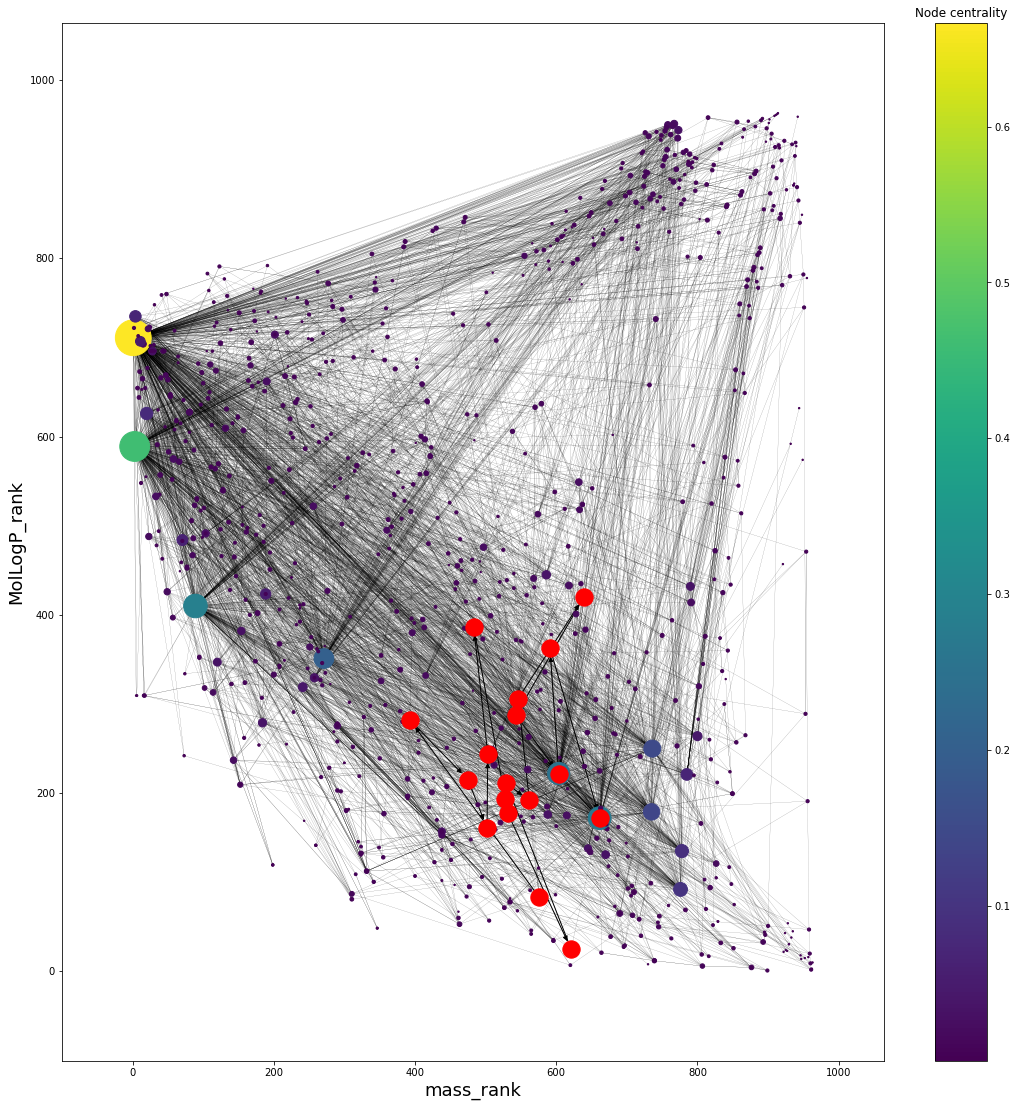

In [140]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_com
import numpy as np
import scipy.sparse
import matplotlib.colors as mcolors
import matplotlib.cm as cm




gem = "1515"
Pathway = "ATP"
x_coord = "mass_rank"
y_coord = "MolLogP_rank"
DescriptorPair = "{}_{}".format(x_coord, y_coord)

fig, ax = plt.subplots(figsize=(15,15))


DriedPeach = pd.read_csv(f"{gem}_edges.csv")
data2 = pd.read_csv(Pathway + "_plot.csv")


#Genome-scale metabolic network

sources = DriedPeach["BiGG"]
targets = DriedPeach["target"]
coordinates = DriedPeach[[x_coord, y_coord]].values


edge_data = zip(sources,targets, coordinates)

H = nx.DiGraph()

for e in edge_data:
    src = e[0]
    dst = e[1]
    c = e[2]

    H.add_node(src, pos = c)
    H.add_edge(src,dst)

H.remove_edges_from(nx.selfloop_edges(H))

pos_BC_gem = nx.get_node_attributes(H,'pos')


# Pathway

sources_2 = data2["BiGG"]
targets_2 = data2['target']
coordinates_2 = data2[[x_coord, y_coord]].values

edge_data_2 = zip(sources_2,targets_2, coordinates_2) # targets

G = nx.DiGraph()

for e in edge_data_2:
    src = e[0]
    dst = e[1]
    c = e[2]

    G.add_node(src, pos = c, node_color = 'red')
    G.add_edge(src,dst)

G.remove_edges_from(nx.selfloop_edges(G))


pos_BC_pathway = nx.get_node_attributes(G,'pos')

# Pathway label offset for overlay
pos_net3_higher = {}
y_off = 40  # offset on the y axis
x_off = 0.0

deg_centrality = nx.degree_centrality(H)
cent = np.fromiter(deg_centrality.values(), float)

centrality = np.fromiter(deg_centrality.values(), float)

degree = nx.degree(H)

degree_values = [v for k , v in degree]

degree_values = np.fromiter(degree_values, float)
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.viridis

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(cent)
plt.tight_layout()
cb = plt.colorbar(scalarmappaple)
cb.ax.set_title("Node centrality")



# Draw GEM network
nx.draw_networkx_nodes(H, pos_BC_gem, node_color=centrality, node_size=degree_values*2)
nx.draw_networkx_edges(H, pos_BC_gem, width = 0.1, arrows = False)

# Draw pathway 
nx.draw_networkx_nodes(G, pos_BC_pathway, node_color = "r")
nx.draw_networkx_edges(G, pos_BC_pathway, width = 1, arrows = True)


limits=plt.axis('on') # turns on axis
ax.set_xlabel(x_coord, fontsize = 18)
# ax.xlabel(x_coord, fontsize = 18)
ax.set_ylabel(y_coord, fontsize =18)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.show()